In [200]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

we define some helper functions:

In [357]:
def plot_img(img, **kwargs):
    """Helper routine to plot array `img`."""
    f, ax = plt.subplots(1, 1, figsize=(3, 3))

    ax.imshow(img, **kwargs)

    ax.axis('off')
    plt.tight_layout()

    return f, ax

def plot_hist(img, **kwargs):
    """Helper routine to plot a histogram of the pixel values of `img`."""

    if len(img.shape) == 3:
        n_channels = 3
    elif len(img.shape) == 2:
        n_channels =1
    
    bins = np.linspace(0, 1, 100)
    if n_channels == 3:
        hist = [np.histogram(img[:,:,i], bins=bins)[0] for i in range(n_channels)]
    else:
        hist = [np.histogram(img[:,:], bins=bins)[0]]


    f, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.tick_params(axis='both', labelsize=0, length = 0)

    for i in range(n_channels):
        ax.plot(bins[:-1], hist[i], color={0: 'red', 1: 'green', 2: 'blue'}[i])

    #ax.set_yscale('log')
    ax.set_ylabel('count', fontsize=16)
    ax.set_xlabel('pixel value', fontsize=16)
    plt.tight_layout()

    return f, ax
    
    

read in some satellite image:

In [122]:
with open('S2B_MSIL2A_20171015T104009_27_9_all_bands.npy', 'rb') as f:
    raw = np.load(f)

# extract and rearrange image bands, scale pixel values to range [0, 1] 
img = np.dstack([raw[3], raw[2], raw[1]])/np.max(raw[1:4])

# Image Normalization

## Image Scaling

underexposed image:

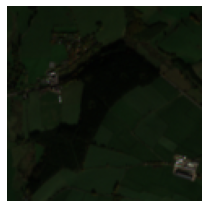

In [175]:
img_underexp = 0.5*img
f, ax = plot_img(img_underexp)

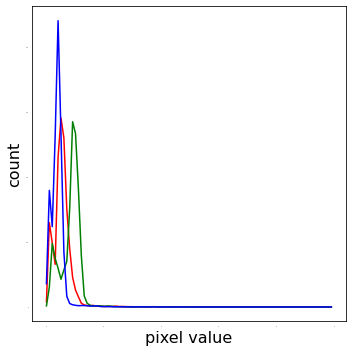

In [124]:
f, ax = plot_hist(0.5*img)

well-exposed image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


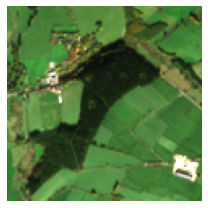

In [130]:
f, ax = plot_img(2.5*img)

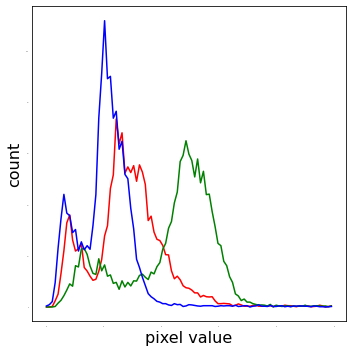

In [131]:
f, ax = plot_hist(2.5*img)

over-exposed image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


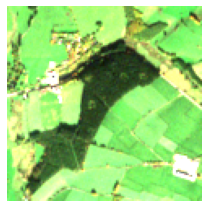

In [128]:
f, ax = plot_img(5*img)

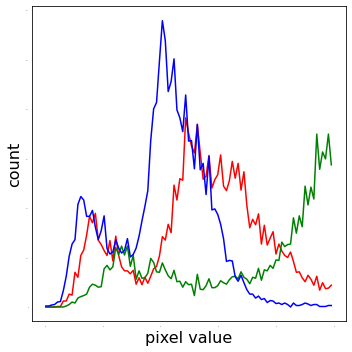

In [129]:
f, ax = plot_hist(5*img)

original image plot and histogram:

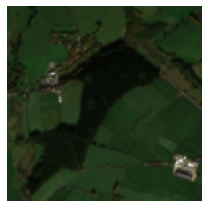

In [189]:
f, ax = plot_img(img)

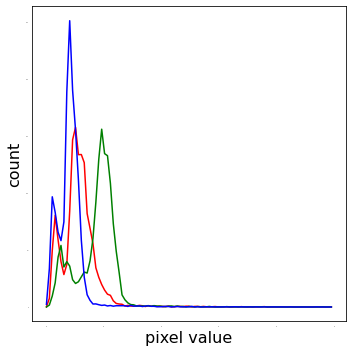

In [137]:
f, ax = plot_hist(img)

use gamma correction for image scaling:

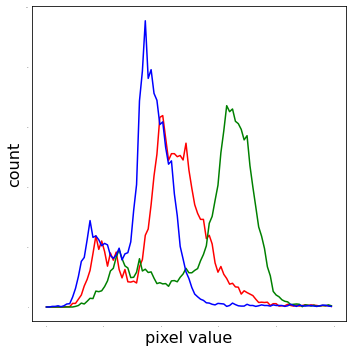

In [136]:
f, ax = plot_hist(2*img**0.7)

## Min-Max Normalization

perform channel-wise min-max normalization (on the underexposed image to better show the effect):

In [181]:
img_channelwisenorm = (img_underexp - np.min(img_underexp, axis=(0,1)))/(np.max(img_underexp, axis=(0,1))-np.min(img_underexp, axis=(0,1)))

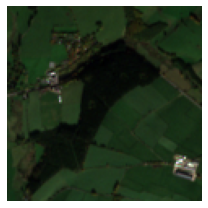

In [182]:
f, ax = plot_img(img_channelwisenorm)

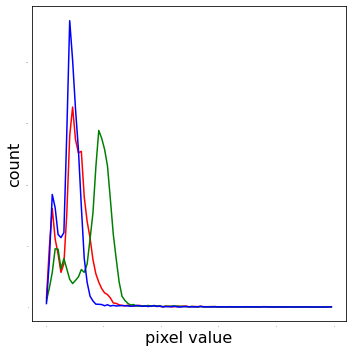

In [183]:
f, ax = plot_hist(img_channelwisenorm)

perform image-wise min-max normalization:

In [184]:
img_norm = (img_underexp - np.min(img_underexp))/(np.max(img_underexp)-np.min(img_underexp))

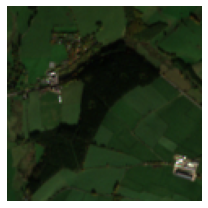

In [185]:
f, ax = plot_img(img_norm)

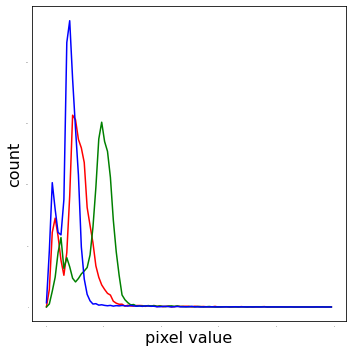

In [186]:
f, ax = plot_hist(img_norm)

### Histogram Equilization

compute cumulative histograms:

In [190]:
bins = np.linspace(0, 1, 100)
hist = [np.histogram(img[:,:,i], bins=bins)[0] for i in range(3)]

cumhist = [np.cumsum(hist[i]) for i in range(3)]

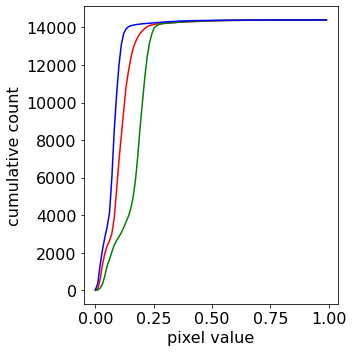

In [196]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.tick_params(axis='both', labelsize=16)

for i in range(3):
    ax.plot(bins[:-1], cumhist[i], color={0: 'red', 1: 'green', 2: 'blue'}[i])

ax.set_ylabel('cumulative count', fontsize=16)
ax.set_xlabel('pixel value', fontsize=16)
plt.tight_layout()

scale cumulative histograms to generate mapping function:

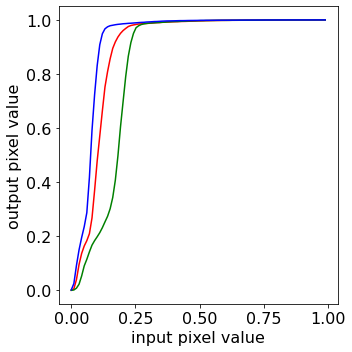

In [209]:
cumhist_scaled = cumhist/np.max(cumhist)

# implement actual mapping as 1d interpolation function 
mapper_r = interp1d(bins[:-1], cumhist_scaled[0], fill_value='extrapolate')
mapper_g = interp1d(bins[:-1], cumhist_scaled[1], fill_value='extrapolate')
mapper_b = interp1d(bins[:-1], cumhist_scaled[2], fill_value='extrapolate')

f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.tick_params(axis='both', labelsize=16)

for i in range(3):
    ax.plot(bins[:-1], cumhist_scaled[i], color={0: 'red', 1: 'green', 2: 'blue'}[i])

ax.set_ylabel('output pixel value', fontsize=16)
ax.set_xlabel('input pixel value', fontsize=16)
plt.tight_layout()

apply mapping function:

In [210]:
img_equalized = np.dstack([mapper_r(img[:,:,0]), mapper_g(img[:,:,1]), mapper_b(img[:,:,2])])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 216x216 with 1 Axes>, <AxesSubplot:>)

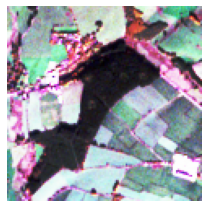

In [211]:
plot_img(img_equalized)

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:xlabel='pixel value', ylabel='count'>)

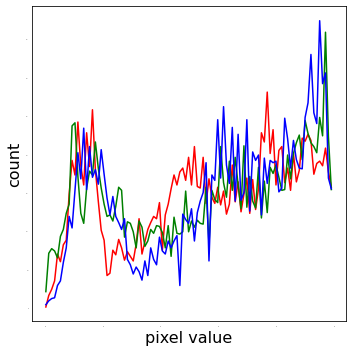

In [212]:
plot_hist(img_equalized)

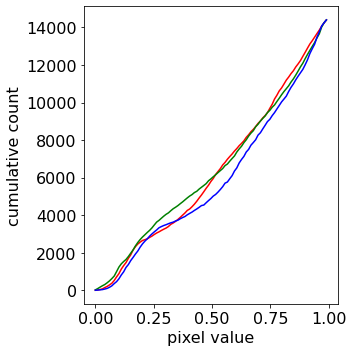

In [213]:
bins = np.linspace(0, 1, 100)
hist_equalized = [np.histogram(img_equalized[:,:,i], bins=bins)[0] for i in range(3)]

cumhist_equalized = [np.cumsum(hist_equalized[i]) for i in range(3)]

f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.tick_params(axis='both', labelsize=16)

for i in range(3):
    ax.plot(bins[:-1], cumhist_equalized[i], color={0: 'red', 1: 'green', 2: 'blue'}[i])

ax.set_ylabel('cumulative count', fontsize=16)
ax.set_xlabel('pixel value', fontsize=16)
plt.tight_layout()

apply partial histogram equalization:

In [226]:
a = 0.3
img_partially_equalized = a*np.dstack([mapper_r(img[:,:,0]), mapper_g(img[:,:,1]), mapper_b(img[:,:,2])]) + (1-a)*img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 216x216 with 1 Axes>, <AxesSubplot:>)

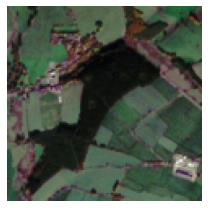

In [227]:
plot_img(img_partially_equalized)

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:xlabel='pixel value', ylabel='count'>)

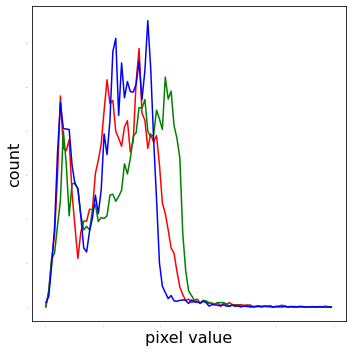

In [228]:
plot_hist(img_partially_equalized)

# Linear Filtering

## Smoothing

In [229]:
from scipy.signal import convolve2d
from scipy.misc import face

img = face(gray=True)

(<Figure size 216x216 with 1 Axes>, <AxesSubplot:>)

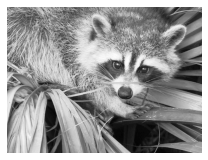

In [233]:
plot_img(img, cmap='Greys_r')

### Mean smoothing 

In [257]:
k_meansmooth = np.ones((30,30))*1/900

img_meansmooth = convolve2d(img, k_meansmooth, mode='same')

(<Figure size 216x216 with 1 Axes>, <AxesSubplot:>)

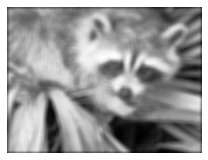

In [258]:
plot_img(img_meansmooth, cmap='Greys_r')

### Gaussian smoothing

In [266]:
from scipy.stats import norm

def gauss_kernel(k):
    """generate Gaussian kernel based on kernel size `k`"""
    x = np.linspace(-3, 3, k+1)
    k_gauss = np.outer(np.diff(norm.cdf(x)), np.diff(norm.cdf(x)))
    return k_gauss/k_gauss.sum()  # normalization

k_gauss = gauss_kernel(30)

(<Figure size 216x216 with 1 Axes>, <AxesSubplot:>)

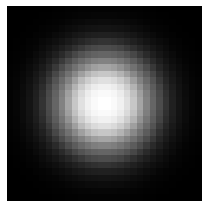

In [255]:
plot_img(k_gauss, cmap='Greys_r')

(<Figure size 216x216 with 1 Axes>, <AxesSubplot:>)

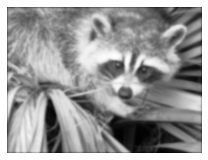

In [259]:
img_gauss = convolve2d(img, k_gauss, mode='same')

plot_img(img_gauss, cmap='Greys_r')

## Edge detection

### Laplace edge detection

The Laplace operator is provided by the second order differential.


In [358]:
k_laplace = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

(<Figure size 216x216 with 1 Axes>, <AxesSubplot:>)

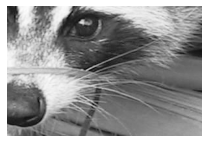

In [359]:
img2 = img[300:500,600:900]
plot_img(img2, cmap='Greys_r')

(<Figure size 216x216 with 1 Axes>, <AxesSubplot:>)

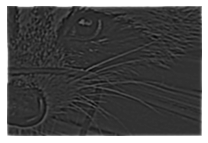

In [362]:
img2_preprocessed = convolve2d(img2, gauss_kernel(9), mode='same')
img2_laplace = convolve2d(img2_preprocessed, k_laplace, mode='same')

plot_img(img2_laplace, cmap='Greys_r')

## Non-linear filters

### Median filtering

we create an image with shot noise

In [363]:
from scipy.stats import poisson

shot_noise = poisson.rvs(5, size=img2.shape)


In [366]:
from numpy.random import randint

noise = np.zeros_like(img2)
noise[randint(low=0, high=img2.shape[0], size=1000), 
      randint(low=0, high=img2.shape[1], size=1000)] = 200

(<Figure size 216x216 with 1 Axes>, <AxesSubplot:>)

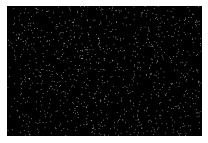

In [367]:
plot_img(noise, cmap='Greys_r', vmin=0, vmax=255)

(<Figure size 216x216 with 1 Axes>, <AxesSubplot:>)

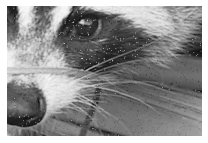

In [368]:
plot_img(img2+noise, cmap='Greys_r')

first try to denoise with Gaussian blur:

(<Figure size 216x216 with 1 Axes>, <AxesSubplot:>)

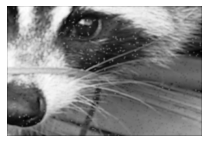

In [370]:
img2_gauss = convolve2d(img2+noise, gauss_kernel(5), mode='same')
plot_img(img2_gauss, cmap='Greys_r')

now try denoising with a median filter (implemented in skimage):

(<Figure size 216x216 with 1 Axes>, <AxesSubplot:>)

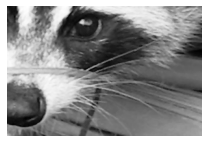

In [372]:
from skimage.filters import median

img2_median = median(img2+noise)
plot_img(img2_median, cmap='Greys_r')

# Fourier Transform

In [401]:
x = np.linspace(-2, 2, 1000)

f_1 = 4/np.pi*np.sin(np.pi/2)*np.cos(2*np.pi*x)
f_3 = 4/np.pi*np.sin(np.pi/2)*np.cos(2*np.pi*x)+4/(3*np.pi)*np.sin(3/2*np.pi)*np.cos(6*np.pi*x)
f_5 = 4/np.pi*np.sin(np.pi/2)*np.cos(2*np.pi*x)+4/(3*np.pi)*np.sin(3/2*np.pi)*np.cos(6*np.pi*x)+1/np.pi*np.sin(5/2*np.pi)*np.cos(10*np.pi*x)
f_9 = 4/np.pi*np.sin(np.pi/2)*np.cos(2*np.pi*x)+4/(3*np.pi)*np.sin(3/2*np.pi)*np.cos(6*np.pi*x)+1/np.pi*np.sin(5/2*np.pi)*np.cos(10*np.pi*x)+4/(7*np.pi)*np.sin(7/2*np.pi)*np.cos(14*np.pi*x)+4/(9*np.pi)*np.sin(9/2*np.pi)*np.cos(18*np.pi*x)


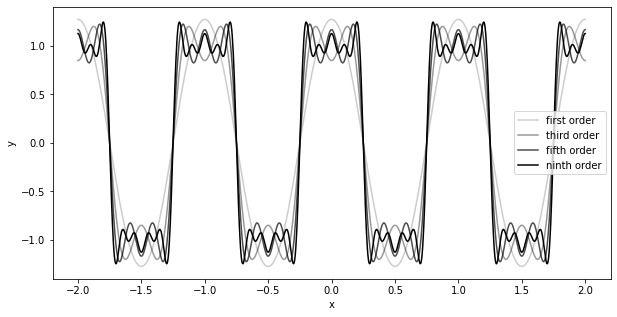

In [410]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(x, f_1, color='black', alpha=0.2, label='first order')
ax.plot(x, f_3, color='black', alpha=0.4, label='third order')
ax.plot(x, f_5, color='black', alpha=0.7, label='fifth order')
ax.plot(x, f_9, color='black', label='ninth order')

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.legend()

In [423]:
from scipy.fftpack import dct, idct

img2_dct = dct(dct(img2.T, norm='ortho').T, norm='ortho')

img2_dct.shape

(200, 300)

/tmp/ipykernel_39987/1218912859.py:1: RuntimeWarning: divide by zero encountered in log10
  plot_img(np.log10(img2_dct[:20, :20]-img2_dct.min()))


(<Figure size 216x216 with 1 Axes>, <AxesSubplot:>)

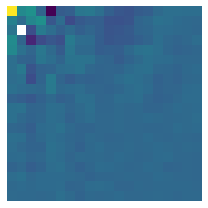

In [432]:
plot_img(np.log10(img2_dct[:20, :20]-img2_dct.min()))

(<Figure size 216x216 with 1 Axes>, <AxesSubplot:>)

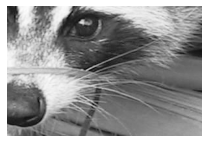

In [440]:
plot_img(idct(idct(img2_dct[:200,:300].T, norm='ortho').T, norm='ortho'), cmap='Greys_r') 